<a href="https://colab.research.google.com/github/ananyashrimali03/Strategy-and-Decision/blob/main/_3_Intent_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HRI In-Class Exercise 3: Learning from Demonstration and Intent Inference

In this in-class assignment, we will walk through intent inference, and intent expression in a simple gridworld environment.


In [ ]:
# Preliminaries
import numpy as np
from enum import IntEnum
import itertools as iter
import random
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats

First, we will define a simple grid world environment with obstacles. In this world, each grid location can be either free or occupied by an obstacle. The agent starts at a specified start and has to end at one of the specified goal locations. It can move up, down, left, and right, as long as it doesn't leave the grid and it doesn't enter an occupied grid location.

### This part has been done for you, so no code necessary here.

Take 5-10 minutes to review the code.

In [ ]:
# Defining the agent grid world.

class Actions(IntEnum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

class AgentGridworld(object):
    """
    An X by Y gridworld class for an agent in an environment with obstacles.
    """
    Actions = Actions

    def __init__(self, X, Y, obstacles, start, goals):
        """
        Params:
            X [int] -- The width of this gridworld.
            Y [int] -- The height of this gridworld.
            start [tuple] -- Starting position specified in coords (x, y).
            goals [list of tuple] -- List of goal positions specified in coords (x, y).
            obstacles [list] -- List of axis-aligned 2D boxes that represent
                obstacles in the environment for the agent. Specified in coords:
                [[(lower_x, lower_y), (upper_x, upper_y)], [...]]
        """

        assert isinstance(X, int), X
        assert isinstance(Y, int), Y
        assert X > 0
        assert Y > 0

        # Set up variables for Agent Gridworld
        self.X = X
        self.Y = Y
        self.S = X * Y
        self.A = len(Actions)
        self.start = start
        self.goals = goals

        # Set the obstacles in the environment.
        self.obstacles = obstacles


    ###########################
    #### Utility functions ####
    ###########################

    def traj_construct(self, start, goal):
        """
        Construct all trajectories between a start and goal of the shortest length.
        Params:
            start [tuple] -- Starting position specified in coords (x, y).
            goal [tuple] -- Goal position specified in coords (x, y).
        Returns:
            trajs [list] -- Trajectories between start and goal in states (s).
        """
        trajs = []
        def recurse_actions(s_curr, timestep):
            # Recursive action combo construction. Select legal combinations.
            if timestep == T-1:
                if s_curr == s_goal:
                    trajs.append(list(traj))
            else:
                rand_actions = [a for a in Actions]
                random.shuffle(rand_actions)
                for a in rand_actions:
                    s_prime, illegal = self.transition_helper(s_curr, a)
                    if not illegal:
                        traj[timestep+1] = s_prime
                        recurse_actions(s_prime, timestep+1)

        s_start = self.coor_to_state(start[0], start[1])
        s_goal = self.coor_to_state(goal[0], goal[1])
        T = abs(start[0] - goal[0]) + abs(start[1] - goal[1]) + 1
        traj = [None] * T
        traj[0] = s_start
        recurse_actions(s_start, 0)

        return trajs

    def transition_helper(self, s, a):
        """
        Given a state and action, apply the transition function to get the next state.
        Params:
            s [int] -- State.
            a [int] -- Action taken.
        Returns:
            s_prime [int] -- Next state.
            illegal [bool] -- Whether the action taken was legal or not.
        """
        x, y = self.state_to_coor(s)
        assert 0 <= a < self.A

        x_prime, y_prime = x, y
        if a == Actions.LEFT:
            x_prime = x - 1
        elif a == Actions.RIGHT:
            x_prime = x + 1
        elif a == Actions.DOWN:
            y_prime = y + 1
        elif a == Actions.UP:
            y_prime = y - 1
        elif a == Actions.UP_LEFT:
            x_prime, y_prime = x - 1, y - 1
        elif a == Actions.UP_RIGHT:
            x_prime, y_prime = x + 1, y - 1
        elif a == Actions.DOWN_LEFT:
            x_prime, y_prime = x - 1, y + 1
        elif a == Actions.DOWN_RIGHT:
            x_prime, y_prime = x + 1, y + 1
        elif a == Actions.ABSORB:
            pass
        else:
            raise BaseException("undefined action {}".format(a))

        illegal = False
        if x_prime < 0 or x_prime >= self.X or y_prime < 0 or y_prime >= self.Y:
            illegal = True
            s_prime = s
        else:
            s_prime = self.coor_to_state(x_prime, y_prime)
            if self.is_blocked(s_prime):
                illegal = True
        return s_prime, illegal

    def get_action(self, s, sp):
        """
        Given two neighboring waypoints, return action between them.
        Params:
            s [int] -- First waypoint state.
            sp [int] -- Next waypoint state.
        Returns:
            a [int] -- Action taken.
        """
        x1, y1 = self.state_to_coor(s)
        x2, y2 = self.state_to_coor(sp)

        if x1 == x2:
            if y1 == y2:
                return Actions.ABSORB
            elif y1 < y2:
                return Actions.DOWN
            else:
                return Actions.UP
        elif x1 < x2:
            if y1 == y2:
                return Actions.RIGHT
            elif y1 < y2:
                return Actions.DOWN_RIGHT
            else:
                return Actions.UP_RIGHT
        else:
            if y1 == y2:
                return Actions.LEFT
            elif y1 < y2:
                return Actions.DOWN_LEFT
            else:
                return Actions.UP_LEFT

    def is_blocked(self, s):
        """
        Returns True if s is blocked.
        By default, state-action pairs that lead to blocked states are illegal.
        """
        if self.obstacles is None:
            return False

        # Check against internal representation of boxes.
        x, y = self.state_to_coor(s)
        for box in self.obstacles:
            if x >= box[0][0] and x <= box[1][0] and y >= box[1][1] and y <= box[0][1]:
                return True
        return False

    def visualize_grid(self):
        """
        Visualize the world with its obstacles.
        """
        self.visualize_demos([])

    def visualize_demos(self, demos):
        """
        Visualize the world with its obstacles and given demonstration.
        """
        # Create world with obstacles on the map.
        world = 0.5*np.ones((self.Y, self.X))

        # Add obstacles in the world in opaque color.
        for obstacle in self.obstacles:
            lower = obstacle[0]
            upper = obstacle[1]
            world[upper[1]:lower[1]+1, lower[0]:upper[0]+1] = 1.0

        fig1, ax1 = plt.subplots()
        plt.imshow(world, cmap='Greys', interpolation='nearest')

        # Plot markers for start and goal
        plt.scatter(self.start[0], self.start[1], c="orange", marker="o", s=100)
        for goal in self.goals:
            plt.scatter(goal[0], goal[1], c="orange", marker="x", s=300)

        # Plot demonstrations
        for t, demo in enumerate(demos):
            demo_x = []
            demo_y = []
            for s in demo:
                x, y = self.state_to_coor(s)
                demo_x.append(x)
                demo_y.append(y)
            step = t/float(len(demos)+1)
            col = ((1*step), (0*step), (0*step))
            plt.plot(demo_x,demo_y, c=col)

        plt.xticks(range(self.X), range(self.X))
        plt.yticks(np.arange(-0.5,self.Y+0.5),range(self.Y+1))
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
        ax1.set_yticks([])
        ax1.set_xticks([])
        ax = plt.gca()
        plt.minorticks_on
        ax.grid(True, which='both', color='black', linestyle='-', linewidth=2)
        plt.show(block=False)


    #################################
    # Conversion functions
    #################################
    # Helper functions convert between state number ("state") and discrete coordinates ("coor").
    #
    # State number ("state"):
    # A state `s` is an integer such that 0 <= s < self.S.
    #
    # Discrete coordinates ("coor"):
    # `x` is an integer such that 0 <= x < self.X. Increasing `x` corresponds to moving east.
    # `y` is an integer such that 0 <= y < self.Y. Increasing `y` corresponds to moving south.
    #
    #################################

    def state_to_coor(self, s):
        """
        Params:
            s [int] -- The state.
        Returns:
            x, y -- The discrete coordinates corresponding to s.
        """
        assert isinstance(s, int)
        assert 0 <= s < self.S
        y = s % self.Y
        x = s // self.Y
        return x, y

    def coor_to_state(self, x, y):
        """
        Convert discrete coordinates into a state, if that state exists.
        If no such state exists, raise a ValueError.
        Params:
            x, y [int] -- The discrete x, y coordinates of the state.
        Returns:
            s [int] -- The state.
        """

        x, y = int(x), int(y)
        if not(0 <= x < self.X):
            raise ValueError(x, self.X)
        if not (0 <= y < self.Y):
            raise ValueError(y, self.Y)

        return (x * self.Y) + (y)


## Construct a Gridworld (Markov Decision Process)


Let's create a 6x8 grid world with 2 obstacles. For now, let's set the start in the lower left corner and a goal in the upper right corner.

### The code is provided for this so, just run the cell below.

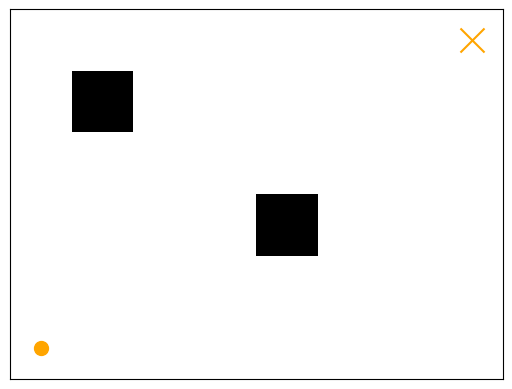

In [ ]:
# Build grid world.
sim_height = 6
sim_width = 8
obstacles = [[[1,1], [1,1]] , [[4,3],[4,3]]]
start = [0, 5]
goals = [[7, 0]]
gridworld = AgentGridworld(sim_width, sim_height, obstacles, start, goals)
gridworld.visualize_grid()

Something that will become very important later on is a set of all of the feasible trajectories of fixed length between the start and goal, $\xi\in\Xi$:

Just run the cell below.

In [ ]:
SG_trajs = gridworld.traj_construct(start, goals[0])

Let's take a look at one of the trajectories.

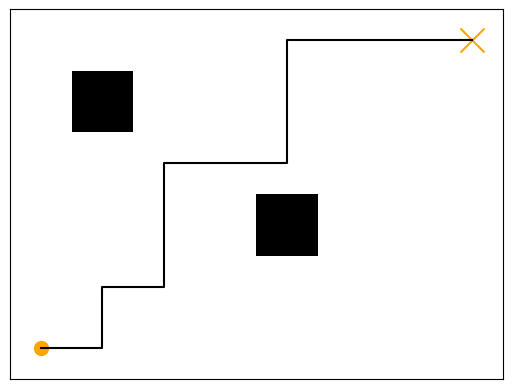

In [ ]:
gridworld.visualize_demos([SG_trajs[0]])

## (a) TODO (5 points): Visualize and count the set of feasible trajectories between start and goal.

HINT: Recall that we ran the following line of code to construct feasible trajectories from start to goal.


```
# SG_trajs = gridworld.traj_construct(start, goals[0])
```

To visualize trajectories (aka. demos), we need to call

```
# gridworld.visualize_demos()
```
with the list of demos we want to visualize.



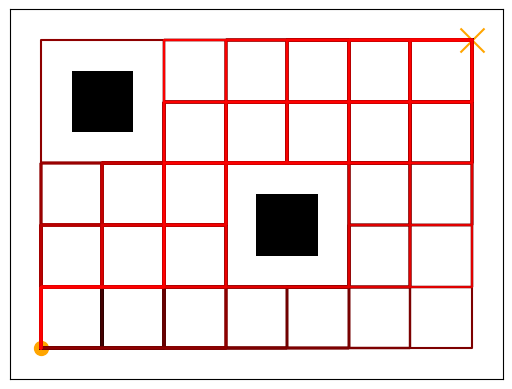

In [ ]:
gridworld.visualize_demos(SG_trajs)

## (a) TODO (5 points) How many feasible trajectories exist between start and goal? ______

Hint: Compute the length of


```
SG_trajs
```



In [ ]:
len(SG_trajs)

457

# Simulated Human
Now let's create a simulated human to produce some demonstrations that our agent will learn from. The human has access to the grid world, and, therefore, to the trajectories $\xi\in\Xi$ that are feasible in the grid world, but we need to implement a way of selecting amongst those trajectories. We need two components for this: a <b>cost function</b>, and an <b>observation model</b>.

#### The Cost Function
The cost function $C : \Xi \rightarrow \mathbb{R}$ maps trajectories to a real-numbered score and defines how much the human prefers some trajectories in the grid world over the others. To make computation tractable, this cost function is typically parameterized by some *weight vector* $\theta$: $C_\theta$. While the cost could operate directly on the state trajectory, it is more common (also for tractability's sake) to write it as a function of *features* $\Phi : \Xi \rightarrow \mathbb{R}^n$ - aspects of behavior that the person might care about. For example, the feature vector of a trajectory $\Phi(\xi)$ could be the trajectory's total distance to an obstacle, its jerk, its average $x$ coordinate, etc. In class, we saw the cost written as a linear combination of features $C_\theta = \theta^T\Phi$, and we'll use this same cost structure in the homework.

We can think of $\theta$ as a parameter that determines how much the human prioritizes certain features over others. We will play with different weight vectors $\theta$ later on and see how that affects the demonstrations produced. Before we do this, **we need to define what features $\Phi$ matter to the simulated human we're creating**. The implementation below already defines some example features;
## (b) TODO (20 points): <b>fill in the `dist_to_goals` function</b>,
which should implement a Euclidean distance to all **goals** in the environment.

<b>The `dist_to_obstacles` function has been done for you</b>,
which implements a Euclidean distance to all obstacles in the environment.

In [ ]:
# Take a quick look at obstacles
gridworld.obstacles

[[[1, 1], [1, 1]], [[4, 3], [4, 3]]]

In [ ]:
# Take a quick look at goals
gridworld.goals

[[7, 0]]

In [ ]:
#################################
#### Featurization functions ####
#################################

####### Obstacles Feature #######

def obstacles_feature(traj):
    """
    Compute obstacle feature values for all obstacles and the entire trajectory.
    The obstacle feature consists of distance from the obstacle.
    Params:
        traj [list] -- The trajectory.
    Returns:
        obstacle_feat [list] -- A list of obstacle features per obstacle.
    """
    obstacle_feat = np.zeros(len(gridworld.obstacles))
    for s in traj:
        obstacle_feat += np.asarray(dist_to_obstacles(s))
    return obstacle_feat.tolist()

def dist_to_obstacles(s):
    """
    Compute distance from state s to the obstacles in the environment.
    Params:
        s [int] -- The state.
    Returns:
        distances [list] -- The distance to the obstacles in the environment.
    """
    x, y = gridworld.state_to_coor(s)
    distances = []

    # Compute delta x and delta y in distance from obstacle
    for obstacle in gridworld.obstacles:
        # THIS PART HAS BEEN PROVIDED FOR YOU:
        dx = min(abs(x - obstacle[0][0]), abs(x - obstacle[1][0]))
        dy = min(abs(y - obstacle[0][1]), abs(y - obstacle[1][1]))
        dist = np.linalg.norm([dx, dy])
        ################
        distances.append(dist)
    return distances

####### Goal Feature #######

def goals_feature(traj):
    """
    Compute goal feature values for all goals and the entire traj.
    The goal feature consists of distance from the obstacle.
    Params:
        traj [list] -- The trajectory.
    Returns:
        goal_feat [list] -- The distance to the goals in the environment.
    """
    goal_feat = np.zeros(len(gridworld.goals))
    for s in traj:
        goal_feat += np.asarray(dist_to_goals(s))
    return goal_feat.tolist()

def dist_to_goals(s):
    """
    Compute distance from state s to the goal in the environment.
    Params:
        s [int] -- The state.
    Returns:
        distance [float] -- The distance to the goals in the environment.
    """
    x, y = gridworld.state_to_coor(s)
    distances = []
#
    for goal in gridworld.goals:
        ####
        # FILL IN THIS PART HERE
        dist = np.sqrt((goal[0]-x) ** 2 + (goal[1]-y)**2)

        distances.append(dist)
    return distances

####### Coordinate Features #######

def average_x_feature(traj):
    """
    Compute average x feature value for the entire trajectory.
    Params:
        traj [list] -- The trajectory.
    Returns:
        avgx_feat [float] -- The average x feature value for entire traj.
    """
    x_coords = [gridworld.state_to_coor(s)[0] for s in traj]
    return np.mean(x_coords)

def average_y_feature(traj):
    """
    Compute average y feature value for the entire trajectory.
    Params:
        traj [list] -- The trajectory.
    Returns:
        avgy_feat [float] -- The average y feature value for entire traj.
    """
    y_coords = [gridworld.state_to_coor(s)[1] for s in traj]
    return np.mean(y_coords)


####### Utils #######

def featurize(traj, feat_list, scaling_coeffs=None):
    """
    Computes the user-defined features for a given trajectory.
    Params:
        traj [list] -- A list of states the trajectory goes through.
    Returns:
        features [array] -- A list of feature values.
    """
    features = []
    for feat in range(len(feat_list)):
        if feat_list[feat] == 'goals':
            features.extend(goals_feature(traj))
        elif feat_list[feat] == 'obstacles':
            features.extend(obstacles_feature(traj))
        elif feat_list[feat] == 'avgx':
            features.append(average_x_feature(traj))
        elif feat_list[feat] == 'avgy':
            features.append(average_y_feature(traj))
    if scaling_coeffs is not None:
        for feat in range(len(features)):
            features[feat] = (features[feat] - scaling_coeffs[feat]["min"]) / (scaling_coeffs[feat]["max"] - scaling_coeffs[feat]["min"])
    return np.asarray(features)

def feat_scale_construct(feat_list):
    """
    Construct scaling constants for the features available.
    """
    # First featurize all trajectories with non-standard features.
    Phi_nonstd = np.array([featurize(xi, feat_list) for xi in SG_trajs])

    # Compute scaling coefficients depending on what feat_scaling is
    scaling_coeffs = []
    for Phi in Phi_nonstd.T:
        min_val = min(Phi)
        max_val = max(Phi)
        coeffs = {"min": min_val, "max": max_val}
        scaling_coeffs.append(coeffs)
    return scaling_coeffs

def visualize_feature(feat_vals, idx):
    """
    Visualize the world with its obstacles and given demonstration.
    """
    # Create world with obstacles on the map.
    world = np.ones((gridworld.Y, gridworld.X))
    for s in range(gridworld.S):
        x, y = gridworld.state_to_coor(s)
        world[y][x] = feat_vals[s][idx]

    # Add obstacles in the world in opaque color.
    for obstacle in gridworld.obstacles:
        lower = obstacle[0]
        upper = obstacle[1]
        world[upper[1]:lower[1]+1, lower[0]:upper[0]+1] = 10.0

    fig1, ax1 = plt.subplots()
    plt.imshow(world, cmap='Greys', interpolation='nearest')

    # Plot markers for start and goal
    plt.scatter(gridworld.start[0], gridworld.start[1], c="orange", marker="o", s=100)
    for goal in gridworld.goals:
        plt.scatter(goal[0], goal[1], c="orange", marker="x", s=300)

    plt.xticks(range(gridworld.X), range(gridworld.X))
    plt.yticks(np.arange(-0.5,gridworld.Y+0.5),range(gridworld.Y+1))
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax = plt.gca()
    plt.minorticks_on
    ax.grid(True, which='both', color='black', linestyle='-', linewidth=2)
    plt.show(block=False)

Now let's visualize each feature to make sure your implementation is correct.

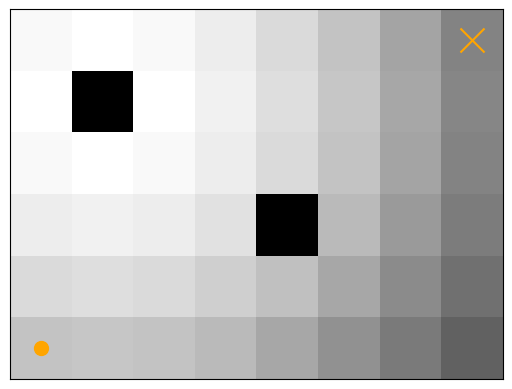

In [ ]:
# Left obstacle. You should see the cells get darker the farther they are from the left obstacle.
feat_list = ["obstacles"]
state_feat_vals = [featurize([s], feat_list) for s in range(gridworld.S)]
visualize_feature(state_feat_vals, 0)

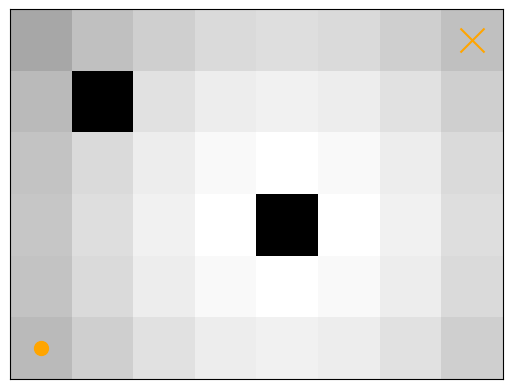

In [ ]:
# Right obstacle. You should see the cells get darker the farther they are from the right obstacle.
feat_list = ["obstacles"]
state_feat_vals = [featurize([s], feat_list) for s in range(gridworld.S)]
visualize_feature(state_feat_vals, 1)

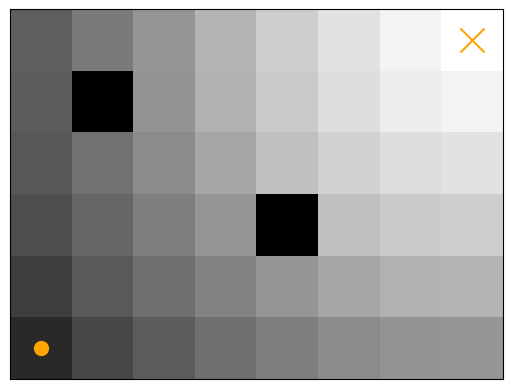

In [ ]:
# Goal. You should see the cells get darker the farther they are from the goal.
feat_list = ["goals"]
state_feat_vals = [featurize([s], feat_list) for s in range(gridworld.S)]
visualize_feature(state_feat_vals, 0)

# The Observation Model
In class, we learned about the IRL observation model - the Boltzmann model - where trajectories are chosen in proportion to their exponentiated negative cost: $$P(\xi\mid\theta) = \frac{e^{-\beta\theta^T\Phi(\xi)}}{\sum_{\bar\xi \in \Xi} e^{-\beta\theta^T\Phi(\bar\xi)}} \enspace .$$

Here, $\beta$ is an inverse temperature parameter that controls how rational or noisy the human is when giving demonstrations: high $\beta$s produce demonstrations closer to optimal, while lower ones produce noisier demonstrations.

We will now implement the Boltzmann noisy rationality model for a given $\theta$ and $\beta$.
## (c) TODO (20 points): <b>Fill in the `observation_model` function below</b>, assuming that $\Phi(\xi)$ and $\Phi(\bar\xi),\forall \bar\xi\in\Xi$ are passed in already as arguments.

In [ ]:
def observation_model(Phi_xi, Phi_xibar, theta, beta):
    """
    Finds observation model for given demonstrated features, using initialized model.
    Params:
        Phi_xi [array] -- The cost features for an observed trajectory.
        Phi_xibar [list] -- A list of the cost features for all trajectories in the grid.
        theta [list] -- The preference parameter.
        beta [float] -- The rationality coefficient.
    Returns:
        P_xi_bt [float] -- P(xi | theta, beta)
    """
    #####
    # YOUR CODE HERE
    C_xi = -beta * np.dot(Phi_xi, theta)
    C_xi_bar = [-beta * np.dot(Phi_x, theta) for Phi_x in Phi_xibar]
    P_xi_bt = np.exp(C_xi)/sum(np.exp(C_xi_bar))


    ################
    return P_xi_bt

Given the cost model and the observation model, the simulated human can now sample demonstrations. The function below does this by generating the feature vector for all $\xi \in \Xi$, computing the Boltzmann probability for all of them, and sampling according to those probabilities.

In [ ]:
def sample_demonstrations(theta, beta, samples):
    """
    Sample <samples> demonstrations for a given theta and beta.
    Params:
        theta [list] -- The preference parameter.
        beta [float] -- The rationality coefficient.
        samples [int] -- Number of demonstrations to be sampled.
    """
    # Generate feature values for all trajectories in the gridworld.
    Phi_xibar = [featurize(xi, feat_list, scaling_coeffs) for xi in SG_trajs]

    # Create the xi observation model for all trajectories.
    P_xi = [observation_model(Phi, Phi_xibar, theta, beta) for Phi in Phi_xibar]

    # Sample <samples> trajectories using this distribution.
    traj_idx = np.random.choice(len(P_xi), samples, p=P_xi)

    # Return trajectories given by traj_idx
    return [SG_trajs[i] for i in traj_idx]

## Playing around with various "humans".

Now we're ready to create the simulated human and sample demonstrations. Let's say our human cares about the distances to the obstacles in the environment, and let's see how varying $\theta$ and $\beta$ changes their demonstrations.

### (d) TODO (10 points): Changing Beta: Let's try with an optimal (high $\beta$=1000) simulated human.

<b>Change the $\beta$ parameter below</b> to create a human that almost always produces the optimal trajectory (pick a $\beta$ that doesn't make the Python floating point system overflow, i.e. $|\beta| \leq 1000$).

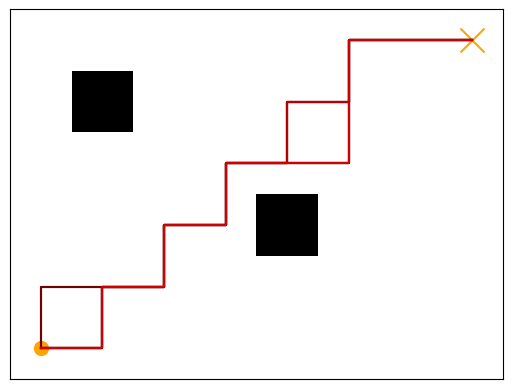

In [ ]:
# Define parameters for simulated human.
feat_list = ["obstacles"]
num_features = 2
scaling_coeffs = feat_scale_construct(feat_list) # Used for normalizing feature values.
real_theta = np.array([1.0, 1.0])
num_demos = 10

# YOUR CODE HERE: TODO: Set beta high
real_beta = 500

# Wants to stay close to both obstacles.
demos = sample_demonstrations(real_theta, real_beta, num_demos)
gridworld.visualize_demos(demos)

### (d) TODO (10 points): Changing Beta: Let's try with a noisy (low $\beta$=1000) simulated human.

Now <b>change the $\beta$ parameter below</b> to create a human that essentially picks trajectories randomly (pick a $\beta$ that doesn't make the Python floating point system overflow, i.e. $|\beta| \leq 1000$).

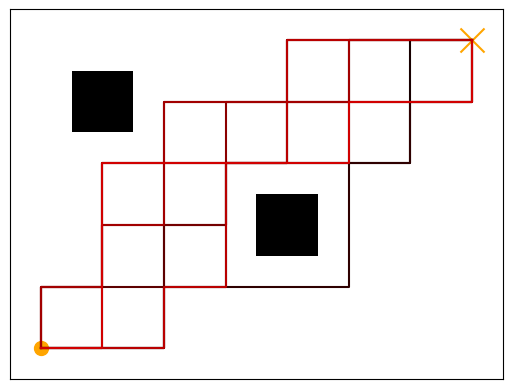

In [ ]:
# Define parameters for simulated human.
feat_list = ["obstacles"]
num_features = 2
scaling_coeffs = feat_scale_construct(feat_list) # Used for normalizing feature values.
real_theta = np.array([1.0, 1.0])
num_demos = 10

# YOUR CODE HERE: TODO: Set beta low
real_beta = 2

# Wants to stay close to both obstacles.
demos = sample_demonstrations(real_theta, real_beta, num_demos)
gridworld.visualize_demos(demos)

We can see that low values of $\beta$ lead to more noisy human trajectories. Since $\theta$ remains the same, the human cares to minimize distance to both obstacles.

### (d) TODO (5 points): In this GridWorld environment, what is the difference in the behaviors of the demonstrations when $\beta$ is high versus when $\beta$ is low?

Write your response in the cell below.

When beta is high, it shows the optimal behavior. The simulated human would follow the path that is nearly equal to their preference and would be taking an efficient path. On the other hand, when the beta is low, the simulated human takes multiple different paths. Also the ones that are not very efficient. Overall, beta is the controling factor of the rationality where higher beta value is optimum and lower beta value is towards more randomness.

## Now, we can see that if we change $\theta$ = [1,0], the simulated human wants to stay close to left obstacle, doesn't care about the other one.

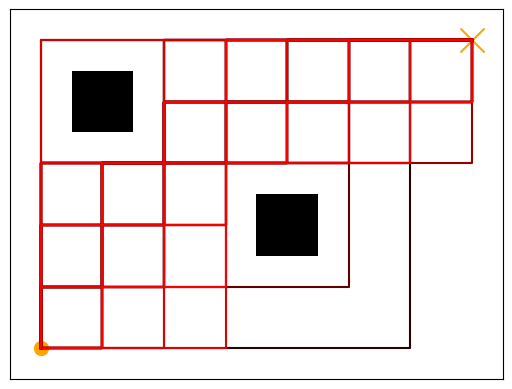

In [ ]:
# Wants to stay close to left obstacle, doesn't care about the other one.
demos = sample_demonstrations(np.array([1.0, 0.0]), 10.0, 100)
gridworld.visualize_demos(demos)

## Now, we can see that if we change $\theta$ = [-1,1], the simulated human wants to stay far away from the left obstacle, and close to the other one.

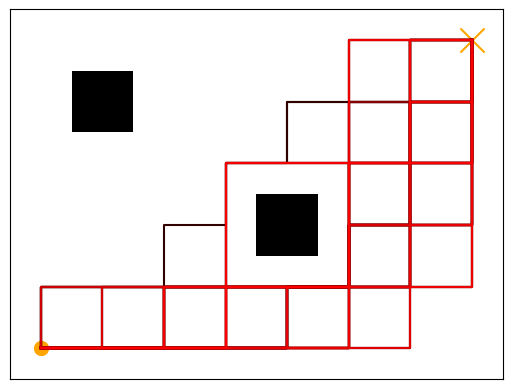

In [ ]:
# Wants to stay far from the left obstacle, close to the other one.
demos = sample_demonstrations(np.array([-1.0, 1.0]), 10.0, 100)
gridworld.visualize_demos(demos)

## Now, we can see that if we change $\theta$ = [-1,0], the simulated human wants to stay far away from the left obstacle, and doesn't care about the other one.

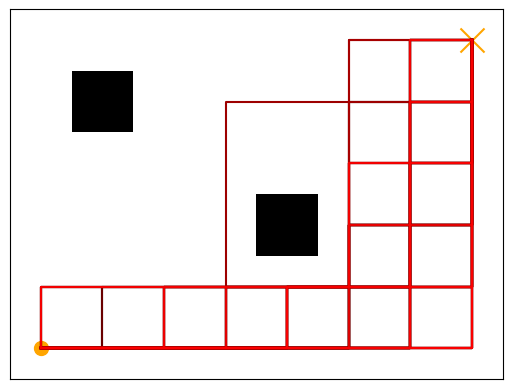

In [ ]:
# Wants to stay far from the left obstacle, doesn't care about the other one.
demos = sample_demonstrations(np.array([-1.0, 0.0]), 10.0, 100)
gridworld.visualize_demos(demos)

# Intent Inference: Learning from Demonstrations

Now that we have some demonstrations from the simulated human, we want to infer just by observing their behavior how they chose that particular motion, i.e. what $\theta$ and $\beta$ parameters they used to generate demonstrations. This is the typical Inverse Reinforcement Learning (IRL) problem, which seeks to explain an observed demonstration by uncovering the demonstrator’s unknown objective function. We're going to implement Bayesian IRL to do so: $$P(\theta \mid\xi) = \frac{P(\xi\mid\theta)P(\theta)}{\sum_{\bar\theta}P(\xi\mid\bar\theta)P(\bar\theta)} \enspace.$$

From the discussion in class, remember that Bayesian IRL is intractable because the summation (integral) is infeasible to compute over continuous spaces. To make it tractable, we discretize the possible set of $\theta$ values.

To make this even simpler, we will assume we are learning from a rational human. $\beta=100$

In [ ]:
# Inference parameters
theta_vals =  [-1.0, 0.0, 1.0]
betas = [100.0]
thetas = list(iter.product(theta_vals, repeat=num_features))
if (0.0,)*num_features in thetas:
    thetas.remove((0.0,)*num_features)
thetas = [w / np.linalg.norm(w) for w in thetas]
thetas = set([tuple(i) for i in thetas])
thetas = [list(i) for i in thetas]

Given the discrete sets of possible $\theta$ and $\beta$ values, as well as the already computed feature vectors for $N$ demonstrations,

## (e) TODO (20 points): <b>fill in the `inference` function below</b> to perform discrete Bayesian inference.

We provide a uniform prior over $\theta$ and $\beta$ that you should use. Hint: use the `observation_model` function you wrote earlier for each demonstration.

In [ ]:
def inference(Phi_xis, thetas, betas):
    """
    Performs inference from given demonstrated features, using initialized model.
    Params:
        Phi_xis [list] -- A list of the cost features for observed trajectories.
        thetas [list] -- Possible theta vectors.
        betas [list] -- Possible beta values.
    Returns:
        P_bt [array] -- Posterior probability P(beta, theta | xi_1...xi_N)
    """
    prior = np.ones((len(betas), len(thetas))) / (len(betas) * len(thetas))

    # Generate feature values for all trajectories in the gridworld.
    Phi_xibar = [featurize(xi, feat_list, scaling_coeffs) for xi in SG_trajs]

    # Calculate P(xi | theta, beta)
    P_xi_bt = np.ones((len(betas), len(thetas)))
    for b, beta in enumerate(betas):
        for t, theta in enumerate(thetas):
            # YOUR CODE HERE
            # HINT: access probability of xi given theta, and our one beta
            # with P_xi_bt[b][t]

            # HINT: P_xi_bt[b][t] is initialized as ones. But we just need to set
            # it equal to observation_model(Phi_xi, Phi_xibar, theta, beta).
            for Phi_xi in Phi_xis:
              P_xi_bt[b][t] *= observation_model(Phi_xi, Phi_xibar, theta, beta)

            #######
    # Calculate b(theta, beta) -> posterior for theta and beta after demonstration
    P_bt = np.multiply(P_xi_bt, prior)
    P_bt = P_bt / sum(sum(P_bt))
    ##########################
    return P_bt

#################################
#### Visualization functions ####
#################################

def visualize_posterior(prob, thetas, betas):
    matplotlib.rcParams.update({'font.size': 15})

    plt.figure()
    plt.imshow(prob, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.clim(0, None)

    weights_rounded = [[round(i,2) for i in j] for j in thetas]
    plt.xticks(range(len(thetas)), weights_rounded, rotation = 'vertical')
    plt.yticks(range(len(betas)), betas)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\beta$')
    plt.title("Joint Posterior Belief")
    plt.show()


Now let's test your inference function. First, for a simulated human with high rationality coefficient $\beta$.

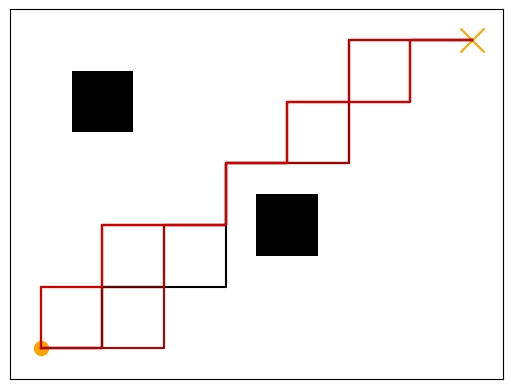

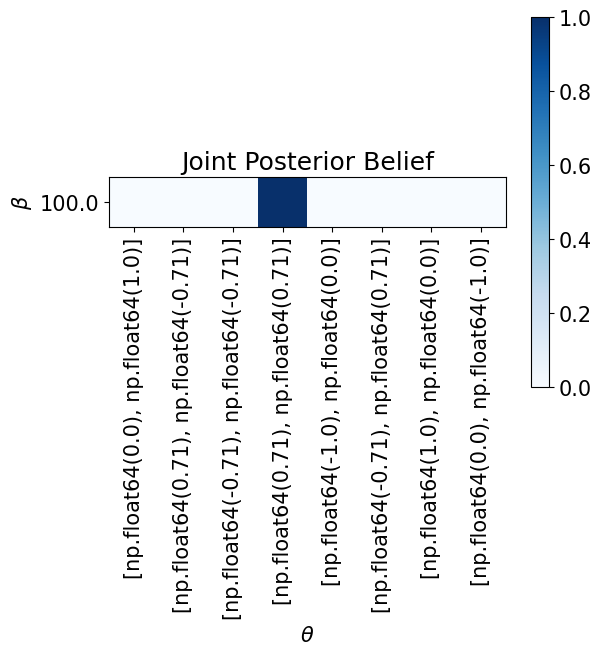

In [ ]:
# Define parameters for simulated human with high rationality, who wants to stay close to both obstacles.
feat_list = ["obstacles"]
num_features = 2
scaling_coeffs = feat_scale_construct(feat_list) # Used for normalizing feature values.
real_theta = np.array([1.0, 1.0])
real_beta = 100.0
num_demos = 10

# Generate demonstrations.
demos = sample_demonstrations(real_theta, real_beta, num_demos)
gridworld.visualize_demos(demos)

# Generate feature values for all demonstrations.
Phi_xis = [featurize(xi, feat_list, scaling_coeffs) for xi in demos]

# Perform and visualize inference.
posterior = inference(Phi_xis, thetas, betas)
visualize_posterior(posterior, thetas, betas)


Now, for a human who wants to avoid the left obstacle?

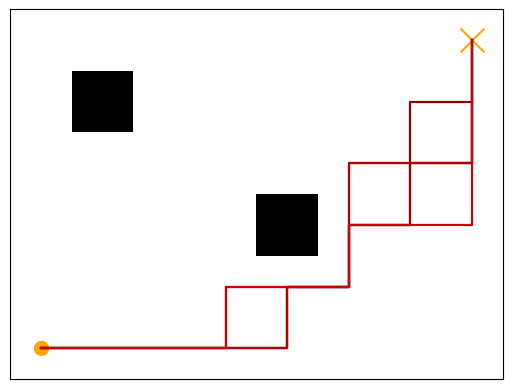

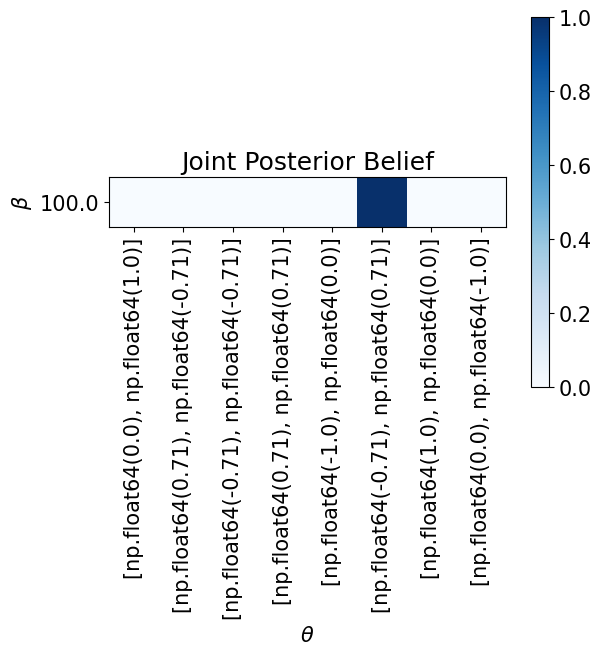

In [ ]:
# Define parameters for simulated human with high rationality, who wants to stay close to both obstacles.
feat_list = ["obstacles"]
num_features = 2
scaling_coeffs = feat_scale_construct(feat_list) # Used for normalizing feature values.
real_theta = np.array([-1.0, 1.0])
real_beta = 100.0
num_demos = 10

# Generate demonstrations.
demos = sample_demonstrations(real_theta, real_beta, num_demos)
gridworld.visualize_demos(demos)

# Generate feature values for all demonstrations.
Phi_xis = [featurize(xi, feat_list, scaling_coeffs) for xi in demos]

# Perform and visualize inference.
posterior = inference(Phi_xis, thetas, betas)
visualize_posterior(posterior, thetas, betas)


## (e) TODO (5 points): For each of the two humans, do the inferred reward weights seem reasonable? Why?

Write your response in the cell below.

For high beta value, the inferred reward weights (theta) should very nearly align with the true theta which is [1.0, 1.0] because high beta means more optimum path, so it strongly shows true cost function. For a low beta, the distribution should show wider range of uncertainty for different theta values. This seems as expected as optimal demonstrations clearly show the intent.

# Goal Inference

We're now going to switch gears to intent inference. Instead of caring about obstacles, our agent is presented with 2 possible goals in the grid world. After seeing a partial trajectory $\xi_{S\rightarrow Q}$ from the start $S$ to an intermediate state $Q$, we want to compute the probability the trajectory is headed to either goal $G$.

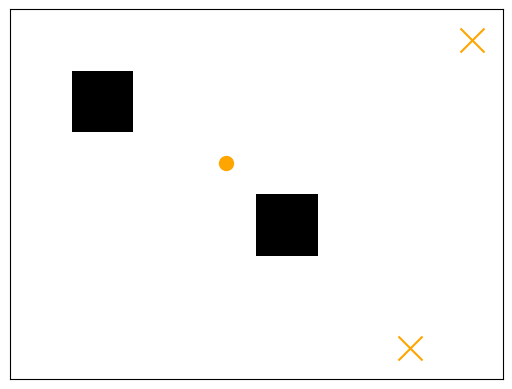

In [ ]:
# Build gridworld.
sim_height = 6
sim_width = 8
obstacles = [[[1,1], [1,1]] , [[4,3],[4,3]]]
start = [3, 2]
goals = [[7, 0], [6, 5]]
feat_list = ["goals"]
gridworld = AgentGridworld(sim_width, sim_height, obstacles, start, goals)
gridworld.visualize_grid()

What we want is $P(G\mid \xi_{S\rightarrow Q})$ for every goal $G\in Goals$.

We will use the following likelihood function:

$$P(G\mid\xi_{S\rightarrow Q}) = \frac{P(\xi_{S\rightarrow Q}\mid G)P(G)}{\sum_{\bar G} P(\xi_{S\rightarrow Q}\mid \bar G)P(\bar G)}\enspace,$$

and $$P(\xi_{S\rightarrow Q}\mid G) = \frac{e^{-C_G(\xi_{S\rightarrow Q})}\sum_{\xi_{Q\rightarrow G}} e^{-C_G(\xi_{Q\rightarrow G})}}{\sum_{\xi_{S\rightarrow G}} e^{-C_G(\xi_{S\rightarrow G})}}\enspace.$$

Let's define the cost function $C_G$ as the cumulative distance from the goal $G$.
## (f) TODO (20 points): Using the above formulae, <b>implement the `goal_inference` function below</b>,
which takes in the partial trajectory $\xi_{S\rightarrow Q}$ and the goal set $Goals$. We provide a uniform prior over goals.

In [ ]:
def goal_inference(traj, goals):
    """
    Performs goal inference from given partial trajectory.
    Params:
        traj [list] -- The partial trajectory xi_SQ.
        goals [list] -- List of goals.
    Returns:
        P_g [array] -- Posterior probability P(G | xi_SQ)
    """
    prior = np.ones(len(goals)) / len(goals)
    P_xi_g = np.ones(len(goals))

    Phi_xi = featurize(traj, feat_list) # Cost from S to Q, under both G1 and G2
    for i in range(len(goals)):
        SG_trajs = gridworld.traj_construct(start, goals[i])
        QG_trajs = gridworld.traj_construct(gridworld.state_to_coor(traj[-1]), goals[i])
        Phi_xiSG = [featurize(xi, feat_list)[i] for xi in SG_trajs] # Distances from S to G_i
        Phi_xiQG = [featurize(xi, feat_list)[i] for xi in QG_trajs] # Distances from Q to G_i

        # YOUR CODE HERE
        C_xi = -Phi_xi[i]
        C_xiQG = [-Phi for Phi in Phi_xiQG]
        C_xiSG = [-Phi for Phi in Phi_xiSG]
        P_xi_g[i] = np.exp(C_xi) * sum(np.exp(C_xiQG))/sum(np.exp(C_xiSG))


    P_g = np.multiply(P_xi_g, prior)
    P_g = P_g / sum(P_g)
    ################
    return P_g


def visualize_inference(prob, goals):
    matplotlib.rcParams.update({'font.size': 15})

    plt.figure()
    plt.imshow([prob], cmap='Oranges', interpolation='nearest')
    plt.colorbar(ticks=[0, 0.5, 1.0])
    plt.clim(0, 1.0)

    plt.xticks(range(len(goals)), goals, rotation = 'vertical')
    plt.yticks([])
    plt.xlabel('Goals')
    plt.title("Inference")
    plt.show()

Let's test your implementation for the following 3 partial trajectories.

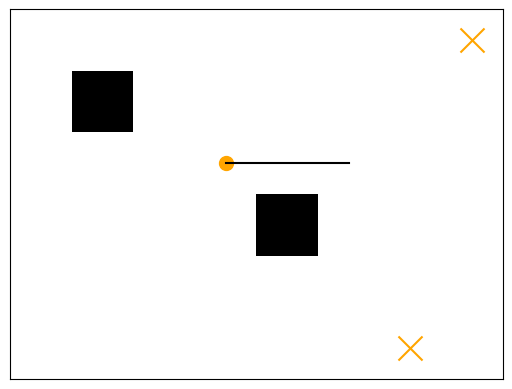

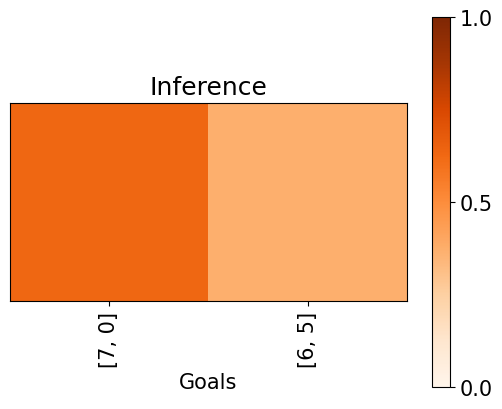

In [ ]:
traj = [(3,2), (4,2), (5,2)]
demo = [gridworld.coor_to_state(x, y) for (x,y) in traj]
gridworld.visualize_demos([demo])

posterior = goal_inference(demo, goals)
visualize_inference(posterior, goals)

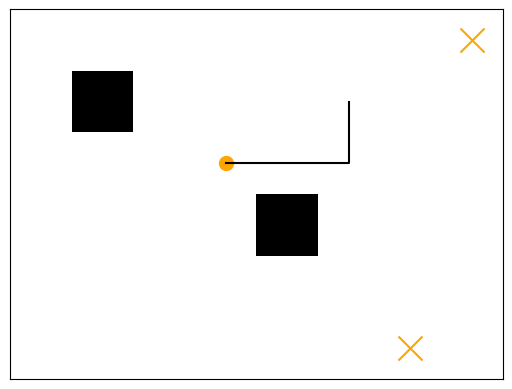

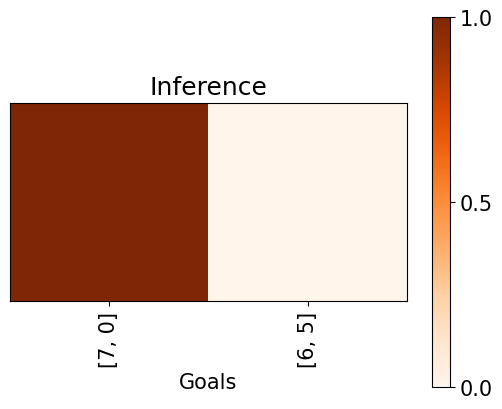

In [ ]:
traj = [(3,2), (4,2), (5,2), (5,1)]
demo = [gridworld.coor_to_state(x, y) for (x,y) in traj]
gridworld.visualize_demos([demo])

posterior = goal_inference(demo, goals)
visualize_inference(posterior, goals)

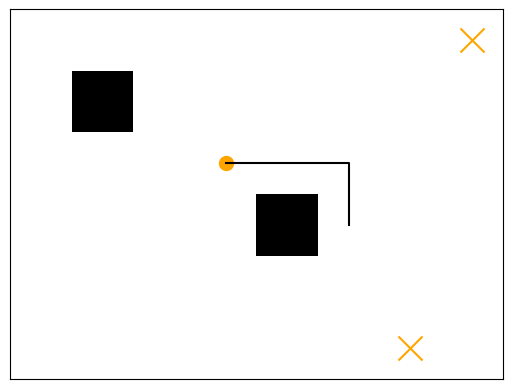

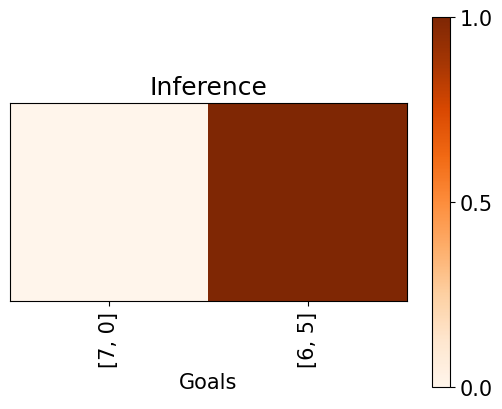

In [ ]:
traj = [(3,2), (4,2), (5,2), (5,3)]
demo = [gridworld.coor_to_state(x, y) for (x,y) in traj]
gridworld.visualize_demos([demo])

posterior = goal_inference(demo, goals)
visualize_inference(posterior, goals)

## (f) TODO (5 points): Compare and contrast the above 3 scenarios. How can measure the "confidence" of the belief? What types of trajectories lead to the most "confident" beliefs?

Write your answer in the cell below.

First case has two possible opportunities between the hypotheses for the two goals, so the observer's confidence is nearly equal for both the goals.
Second scenario has a bias towards the upper right goal and hence the confidence is biased and towards the upper goal too.
The third on is the opposite to the second as the confidence is towards the bottom right goal.